# tile llc model run and distribute parcels runs

J'ai balisé avec deux étoiles (`**`) les parties qui vont sûrement nécessiter des modifs.

Le code principal est dans le [fichier suivant](https://github.com/apatlpo/mit_equinox/blob/master/mitequinox/parcels.py)

- [ ] créer le bon environnement, cf [conda.md](https://github.com/apatlpo/mit_equinox/blob/master/doc/conda.md). Ne pas oublier de mettre à jour les fichiers `jobqueue.yml et distributed.yml` dans `.dask/config/`
- [ ] parcourir ce notebook et `equinox/parcels.py` pour comprendre ce qui est fait globalement
- [ ] Finish implementing main loop around step_window (à la fin)
- [ ] verify particles transition smoothly from one grid to the next (pas du tout testé, peut-être gros morceau)
- [ ] verify what happens when a particle hit the limit of a tile: il faudrait comprendre ce que parcels fait. Je pense que les flotteurs disparaissent. Il faudrait donc trouver un moyen de les récupérer. Cela va sûrement nécessiter de relancer une (des) simulations sur la fenêtre temporelle concernée et sur le nouveau tile dans lequel le flotteur est arrivé.
- [ ] try to speed llc tiling file writing (persist dataset first). It may be faster to rewrite the full (tiled) dataset in a zarr archive.
- [ ] adjust tile size and overlap if necessary (may have to wait full dataset runs)
- [ ] run particle simulation on full dataset (pas du tout testé, peut-être gros morceau)
- [ ] try to change time stepping scheme: RK4
- [ ] write a function to load dataset into xarray or dask.dataframe


In [1]:
import os, shutil

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import geopandas

import dask
from dask.delayed import delayed

%matplotlib inline
from matplotlib import pyplot as plt

import xgcm

from parcels import FieldSet, ParticleSet, ParticleFile, plotTrajectoriesFile
from parcels import JITParticle, ScipyParticle
from parcels import ErrorCode, NestedField, AdvectionEE, AdvectionRK4

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#cluster = LocalCluster(processes=False, n_workers=4, threads_per_worker=2)
#
from dask_jobqueue import PBSCluster
# ** processes and cores may be adjusted in order to have more memory or inversely more computational ressource
cluster = PBSCluster(processes=5, cores=5, walltime='24:00:00')
#cluster = PBSCluster(walltime='04:00:00')
#cluster = PBSCluster()
w = cluster.scale(jobs=5)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.61:55404 Dashboard: http://10.148.1.61:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## setup directories and run parameters

In [3]:
#root_dir = ut.root_data_dir+'parcels/'
root_dir = '/home1/scratch/aponte/parcels/'
#root_dir = '/home1/dunree/slgentil/tmp/parcels/'

# 5x20 tiles
#run_name = 'test'
# 5x5 tiles dij=100 T = 10j dt_window=0.5j overlap=100pts# 5jobs x 5workers
run_name = "test1"
# 5x5 tiles dij=100 T = 364j dt_window=1j overlap=100pts 5jobs x 5workers
#run_name = 'test2'
# 5x5 tiles dij=100 T=10 dt_window=1j overlap=200pts 5jobs x 5workers
#run_name = 'test3'
# 5x5 tiles dij=100 T=365 5jobs x 5workers
#run_name = 'test4'

overwrite = False

# create or overwrite run_dir
run_dir = root_dir+run_name
if os.path.isdir(run_dir):
    if overwrite:
        shutil.rmtree(run_dir)
        os.mkdir(run_dir)
    else:
        #assert False, 'You need to archive the following directory:\n'+run_dir
        pass
else:
    os.mkdir(run_dir)

In [4]:
# simulation parameters

#T = 360? # length of the total run [days]
T = 20 # ** debug
#dt_windows = 5 # time window
dt_windows = 2 # ** debug, 5j devrait être plus approprié je pense
dt_stepping = 1 # hours
dt_outputs = 1 # hours

dij_init = 10 # initial position subsampling compared to llc grid

---

## load llc data

In [5]:
%%time
# load llc data
ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
ds = xr.merge([ds, grd])
ds

CPU times: user 1.67 s, sys: 76 ms, total: 1.75 s
Wall time: 30.3 s


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 8785)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

---

## create tiles

This could be done somewhere else, in another notebook

See `rearrange.ipynb` and `tile.ipynb` for more details

** Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant

In [6]:
%%time
create_tiles = True
tile_dir = os.path.join(run_dir,'tiling/')

if create_tiles:
    
    # ** could filter out tiles that are empty, criterium on Depth or SST should be sufficient
    # create tiler
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(10, 10), overlap=(100, 100))
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 5), overlap=(100, 100))
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 5), overlap=(200, 200))
    tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 5), overlap=(250, 250))
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 5), overlap=(300, 300))
    # store tiler
    tl.store(tile_dir)
    
else:
    tl = pa.tiler(tile_dir=tile_dir)
    
tile_data_dirs = [os.path.join(run_dir,'data_{:03d}'.format(t)) 
                  for t in range(tl.N_tiles)
                 ]

Create new diagnostic directory /home1/scratch/aponte/parcels/test1/tiling/
Tiler stored in /home1/scratch/aponte/parcels/test1/tiling/
CPU times: user 9.46 s, sys: 416 ms, total: 9.87 s
Wall time: 1min 23s


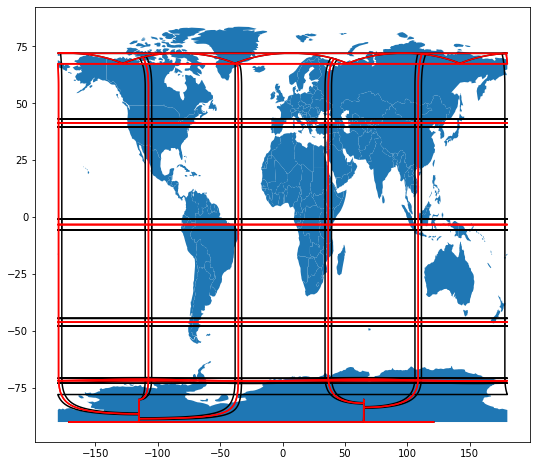

CPU times: user 7.8 s, sys: 9.64 s, total: 17.4 s
Wall time: 6.72 s


In [7]:
%%time
crs = tl.crs_wgs84

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
new_world = world.to_crs(crs)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
new_world.plot(ax=ax)
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color="black")
for b in tl.G['boundaries']:
    b.to_crs(crs).boundary.plot(ax=ax, color="red")
#ax.set_axis_off()
plt.show()

In [8]:
%%time
# create a tree of directories to store data
for t in tile_data_dirs:
    if os.path.isdir(t):
        pass
    else:
        os.mkdir(t)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.8 ms


---

## !!Not used for now!! 

initial distribution of floats is performed within `step_window` now.

We start from llc grid

In [9]:
if False:
    dij = 100 # 1 float every 10 grid points
    x = (grd[['XC','YC']]
              .isel(i=slice(0,None,dij), j=slice(0,None,dij))
              .stack(drifter=('i','j','face'))
              .reset_coords()
             )
    x = x.where(x.Depth>0, drop=True).persist()

    x.plot.scatter(x='XC', y='YC', hue='Depth', s=2, size=10)

In [10]:
if False:
    # assign to tiles
    #df_tiles = tl.assign(lon=x_init.XC, lat=x_init.YC)

    # distributed version
    def assign(lon, lat):
        #import mitequinox.parcels as pa
        #tile_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/tiling/'
        tl = pa.tiler(tile_dir=tile_dir)
        df = tl.assign(lon=lon.squeeze(), lat=lat.squeeze())
        return df.values

    x['tiles'] = xr.apply_ufunc(assign, 
                                x.XC, x.YC, 
                                dask='parallelized', 
                                output_dtypes=[int]
                               ).persist()

In [11]:
if False:
    %time x.plot.scatter(x='XC', y='YC', hue='tiles', s=3, size=10, vmin=0, vmax=tl.N_tiles)
    # dij=100, single node: 1 min35s
    # dij=100, 5x(4,4) cluster: 2 min 5s

In [12]:
if False:
    # drop -1 (drifter without box)
    x = x.where(x.tiles>-1, drop=True)

In [13]:
if False:
    x = (x
         .rename({'XC': 'lon', 'YC': 'lat'})
         .drop_vars(['CS','SN','rA'])
        )

In [14]:
if False:
    # store in file to be processed
    def store_floats_init(x):
        ''' store initial float positions
        '''
        tile = int(x.tiles.values[0])
        x = x.chunk({'drifter': -1}).reset_index('drifter')
        x.to_netcdf(os.path.join(tile_data_dirs[tile], 'x_init.nc'), mode='w')
        return x.mean(dim='drifter')

    x_mean = x.groupby('tiles').apply(store_floats_init)
    x_mean.lon.plot()

--- 

## loop over time windows (main loop)

** we will probably need a restart mechanism the loop from a given time, it may be as simple as changing `np.arange(0,T, dt_windows)` into `np.arange(t_restart,T, dt_windows)`

** we may need to manually clear memory (for example if llc dataset has been persisted within tile_store_llc)


In [ ]:
%%time

tbegin = ut.np64toDate(ds['time'][0].values)
dt_windows = timedelta(days=1.)
#tend = tbegin + 10*dt_windows
tend = tbegin + 365*dt_windows
dt_outputs = timedelta(hours=1.)
dt_step = timedelta(hours=1.)
dij = 100

print('begin =',tbegin.strftime("%Y-%m-%d:%H"))
print('end=',tend.strftime("%Y-%m-%d:%H"))  

    
#for step, t in enumerate(np.arange(t_restart, T, dt_windows)):
for step, t in enumerate(ut.dateRange(tbegin, tend, dt_windows)):
     
    endtime = t+dt_windows+dt_step
    print('-------------------------------------------')
    print('step=',step)
    print('start=',t.strftime("%Y-%m-%d:%H"))
    print('end=',endtime.strftime("%Y-%m-%d:%H")) 
    # load, tile and store llc data
    ds_tiles = pa.tile_store_llc(ds,
                  #slice(t*day2hour, (t+dt_windows)*day2hour, None),
                  slice(t, endtime, None),
                  tl,
                  tile_data_dirs,
                  netcdf=False)
    
    if step >1000:
        for tile in range(tl.N_tiles):
            pa.step_window(tile, step, t, endtime, dt_windows, tl, run_dir,
                                      ds_tile=ds_tiles[tile], init_dij=dij, 
                                      parcels_remove_on_land=True,
                                     ) 
    else:
        dsteps = [delayed(pa.step_window)(tile, step, t, endtime, dt_windows, 
                                          tl, run_dir,
                                          ds_tile=ds_tiles[tile], init_dij=dij, 
                                          parcels_remove_on_land=True,
                                         ) 
                  for tile in range(tl.N_tiles)
                 ]
        dsteps_out = dask.compute(*dsteps) 

        del dsteps
        del dsteps_out
        del ds_tiles

begin = 2011-11-15:00
end= 2012-11-14:00
-------------------------------------------
step= 0
start= 2011-11-15:00
end= 2011-11-16:01


100%|██████████| 25/25 [00:01<00:00, 15.45it/s]


-------------------------------------------
step= 1
start= 2011-11-16:00
end= 2011-11-17:01


100%|██████████| 25/25 [00:01<00:00, 15.57it/s]


-------------------------------------------
step= 2
start= 2011-11-17:00
end= 2011-11-18:01


100%|██████████| 25/25 [00:01<00:00, 15.38it/s]


-------------------------------------------
step= 3
start= 2011-11-18:00
end= 2011-11-19:01


100%|██████████| 25/25 [00:01<00:00, 15.52it/s]


-------------------------------------------
step= 4
start= 2011-11-19:00
end= 2011-11-20:01


100%|██████████| 25/25 [00:01<00:00, 15.39it/s]


-------------------------------------------
step= 5
start= 2011-11-20:00
end= 2011-11-21:01


100%|██████████| 25/25 [00:01<00:00, 15.29it/s]


-------------------------------------------
step= 6
start= 2011-11-21:00
end= 2011-11-22:01


100%|██████████| 25/25 [00:01<00:00, 15.27it/s]


-------------------------------------------
step= 7
start= 2011-11-22:00
end= 2011-11-23:01


100%|██████████| 25/25 [00:01<00:00, 15.55it/s]


-------------------------------------------
step= 8
start= 2011-11-23:00
end= 2011-11-24:01


100%|██████████| 25/25 [00:01<00:00, 15.34it/s]


-------------------------------------------
step= 9
start= 2011-11-24:00
end= 2011-11-25:01


100%|██████████| 25/25 [00:01<00:00, 15.34it/s]


-------------------------------------------
step= 10
start= 2011-11-25:00
end= 2011-11-26:01


100%|██████████| 25/25 [00:01<00:00, 15.46it/s]


-------------------------------------------
step= 11
start= 2011-11-26:00
end= 2011-11-27:01


100%|██████████| 25/25 [00:01<00:00, 13.04it/s]


-------------------------------------------
step= 12
start= 2011-11-27:00
end= 2011-11-28:01


100%|██████████| 25/25 [00:01<00:00, 15.32it/s]


-------------------------------------------
step= 13
start= 2011-11-28:00
end= 2011-11-29:01


100%|██████████| 25/25 [00:01<00:00, 15.52it/s]


-------------------------------------------
step= 14
start= 2011-11-29:00
end= 2011-11-30:01


100%|██████████| 25/25 [00:01<00:00, 15.52it/s]


-------------------------------------------
step= 15
start= 2011-11-30:00
end= 2011-12-01:01


100%|██████████| 25/25 [00:01<00:00, 12.75it/s]


-------------------------------------------
step= 16
start= 2011-12-01:00
end= 2011-12-02:01


100%|██████████| 25/25 [00:01<00:00, 15.28it/s]


-------------------------------------------
step= 17
start= 2011-12-02:00
end= 2011-12-03:01


100%|██████████| 25/25 [00:01<00:00, 15.35it/s]


-------------------------------------------
step= 18
start= 2011-12-03:00
end= 2011-12-04:01


100%|██████████| 25/25 [00:02<00:00, 12.50it/s]


-------------------------------------------
step= 19
start= 2011-12-04:00
end= 2011-12-05:01


100%|██████████| 25/25 [00:01<00:00, 15.37it/s]


-------------------------------------------
step= 20
start= 2011-12-05:00
end= 2011-12-06:01


100%|██████████| 25/25 [00:01<00:00, 15.56it/s]


-------------------------------------------
step= 21
start= 2011-12-06:00
end= 2011-12-07:01


100%|██████████| 25/25 [00:01<00:00, 15.32it/s]


-------------------------------------------
step= 22
start= 2011-12-07:00
end= 2011-12-08:01


100%|██████████| 25/25 [00:01<00:00, 15.50it/s]


-------------------------------------------
step= 23
start= 2011-12-08:00
end= 2011-12-09:01


100%|██████████| 25/25 [00:02<00:00, 12.29it/s]


-------------------------------------------
step= 24
start= 2011-12-09:00
end= 2011-12-10:01


100%|██████████| 25/25 [00:01<00:00, 15.41it/s]


-------------------------------------------
step= 25
start= 2011-12-10:00
end= 2011-12-11:01


100%|██████████| 25/25 [00:01<00:00, 15.33it/s]


-------------------------------------------
step= 26
start= 2011-12-11:00
end= 2011-12-12:01


100%|██████████| 25/25 [00:01<00:00, 15.40it/s]


-------------------------------------------
step= 27
start= 2011-12-12:00
end= 2011-12-13:01


100%|██████████| 25/25 [00:01<00:00, 15.30it/s]


-------------------------------------------
step= 28
start= 2011-12-13:00
end= 2011-12-14:01


100%|██████████| 25/25 [00:01<00:00, 15.50it/s]


-------------------------------------------
step= 29
start= 2011-12-14:00
end= 2011-12-15:01


100%|██████████| 25/25 [00:01<00:00, 15.27it/s]


-------------------------------------------
step= 30
start= 2011-12-15:00
end= 2011-12-16:01


100%|██████████| 25/25 [00:01<00:00, 15.17it/s]


-------------------------------------------
step= 31
start= 2011-12-16:00
end= 2011-12-17:01


100%|██████████| 25/25 [00:01<00:00, 15.22it/s]


-------------------------------------------
step= 32
start= 2011-12-17:00
end= 2011-12-18:01


100%|██████████| 25/25 [00:01<00:00, 15.26it/s]


-------------------------------------------
step= 33
start= 2011-12-18:00
end= 2011-12-19:01


100%|██████████| 25/25 [00:01<00:00, 15.47it/s]


-------------------------------------------
step= 34
start= 2011-12-19:00
end= 2011-12-20:01


100%|██████████| 25/25 [00:01<00:00, 15.29it/s]


-------------------------------------------
step= 35
start= 2011-12-20:00
end= 2011-12-21:01


100%|██████████| 25/25 [00:01<00:00, 15.22it/s]


-------------------------------------------
step= 36
start= 2011-12-21:00
end= 2011-12-22:01


100%|██████████| 25/25 [00:01<00:00, 15.23it/s]


-------------------------------------------
step= 37
start= 2011-12-22:00
end= 2011-12-23:01


100%|██████████| 25/25 [00:01<00:00, 15.49it/s]


-------------------------------------------
step= 38
start= 2011-12-23:00
end= 2011-12-24:01


100%|██████████| 25/25 [00:01<00:00, 15.25it/s]


-------------------------------------------
step= 39
start= 2011-12-24:00
end= 2011-12-25:01


100%|██████████| 25/25 [00:01<00:00, 15.17it/s]


-------------------------------------------
step= 40
start= 2011-12-25:00
end= 2011-12-26:01


100%|██████████| 25/25 [00:02<00:00, 11.54it/s]


-------------------------------------------
step= 41
start= 2011-12-26:00
end= 2011-12-27:01


100%|██████████| 25/25 [00:01<00:00, 15.30it/s]


-------------------------------------------
step= 42
start= 2011-12-27:00
end= 2011-12-28:01


100%|██████████| 25/25 [00:01<00:00, 15.29it/s]


-------------------------------------------
step= 43
start= 2011-12-28:00
end= 2011-12-29:01


100%|██████████| 25/25 [00:01<00:00, 15.24it/s]


-------------------------------------------
step= 44
start= 2011-12-29:00
end= 2011-12-30:01


100%|██████████| 25/25 [00:01<00:00, 15.37it/s]


-------------------------------------------
step= 45
start= 2011-12-30:00
end= 2011-12-31:01


100%|██████████| 25/25 [00:01<00:00, 15.27it/s]


-------------------------------------------
step= 46
start= 2011-12-31:00
end= 2012-01-01:01


100%|██████████| 25/25 [00:01<00:00, 15.33it/s]


-------------------------------------------
step= 47
start= 2012-01-01:00
end= 2012-01-02:01


100%|██████████| 25/25 [00:01<00:00, 15.21it/s]


-------------------------------------------
step= 48
start= 2012-01-02:00
end= 2012-01-03:01


100%|██████████| 25/25 [00:01<00:00, 15.41it/s]


-------------------------------------------
step= 49
start= 2012-01-03:00
end= 2012-01-04:01


100%|██████████| 25/25 [00:01<00:00, 15.43it/s]


-------------------------------------------
step= 50
start= 2012-01-04:00
end= 2012-01-05:01


100%|██████████| 25/25 [00:01<00:00, 15.44it/s]


-------------------------------------------
step= 51
start= 2012-01-05:00
end= 2012-01-06:01


100%|██████████| 25/25 [00:01<00:00, 15.29it/s]


-------------------------------------------
step= 52
start= 2012-01-06:00
end= 2012-01-07:01


100%|██████████| 25/25 [00:01<00:00, 15.26it/s]


-------------------------------------------
step= 53
start= 2012-01-07:00
end= 2012-01-08:01


100%|██████████| 25/25 [00:01<00:00, 15.29it/s]


-------------------------------------------
step= 54
start= 2012-01-08:00
end= 2012-01-09:01


100%|██████████| 25/25 [00:01<00:00, 15.28it/s]


-------------------------------------------
step= 55
start= 2012-01-09:00
end= 2012-01-10:01


100%|██████████| 25/25 [00:01<00:00, 15.33it/s]


-------------------------------------------
step= 56
start= 2012-01-10:00
end= 2012-01-11:01


100%|██████████| 25/25 [00:01<00:00, 15.28it/s]


-------------------------------------------
step= 57
start= 2012-01-11:00
end= 2012-01-12:01


100%|██████████| 25/25 [00:01<00:00, 15.11it/s]


-------------------------------------------
step= 58
start= 2012-01-12:00
end= 2012-01-13:01


100%|██████████| 25/25 [00:01<00:00, 15.33it/s]


-------------------------------------------
step= 59
start= 2012-01-13:00
end= 2012-01-14:01


100%|██████████| 25/25 [00:01<00:00, 15.51it/s]


-------------------------------------------
step= 60
start= 2012-01-14:00
end= 2012-01-15:01


100%|██████████| 25/25 [00:01<00:00, 15.23it/s]


-------------------------------------------
step= 61
start= 2012-01-15:00
end= 2012-01-16:01


100%|██████████| 25/25 [00:01<00:00, 15.28it/s]


-------------------------------------------
step= 62
start= 2012-01-16:00
end= 2012-01-17:01


100%|██████████| 25/25 [00:01<00:00, 15.24it/s]


-------------------------------------------
step= 63
start= 2012-01-17:00
end= 2012-01-18:01


100%|██████████| 25/25 [00:01<00:00, 15.35it/s]


-------------------------------------------
step= 64
start= 2012-01-18:00
end= 2012-01-19:01


100%|██████████| 25/25 [00:01<00:00, 15.45it/s]


-------------------------------------------
step= 65
start= 2012-01-19:00
end= 2012-01-20:01


100%|██████████| 25/25 [00:01<00:00, 15.40it/s]


-------------------------------------------
step= 66
start= 2012-01-20:00
end= 2012-01-21:01


100%|██████████| 25/25 [00:01<00:00, 15.37it/s]


-------------------------------------------
step= 67
start= 2012-01-21:00
end= 2012-01-22:01


100%|██████████| 25/25 [00:01<00:00, 15.41it/s]


-------------------------------------------
step= 68
start= 2012-01-22:00
end= 2012-01-23:01


100%|██████████| 25/25 [00:01<00:00, 15.40it/s]


-------------------------------------------
step= 69
start= 2012-01-23:00
end= 2012-01-24:01


100%|██████████| 25/25 [00:01<00:00, 15.34it/s]


-------------------------------------------
step= 70
start= 2012-01-24:00
end= 2012-01-25:01


100%|██████████| 25/25 [00:01<00:00, 15.04it/s]


-------------------------------------------
step= 71
start= 2012-01-25:00
end= 2012-01-26:01


100%|██████████| 25/25 [00:01<00:00, 15.28it/s]


-------------------------------------------
step= 72
start= 2012-01-26:00
end= 2012-01-27:01


100%|██████████| 25/25 [00:01<00:00, 15.26it/s]


-------------------------------------------
step= 73
start= 2012-01-27:00
end= 2012-01-28:01


100%|██████████| 25/25 [00:01<00:00, 15.21it/s]


-------------------------------------------
step= 74
start= 2012-01-28:00
end= 2012-01-29:01


100%|██████████| 25/25 [00:01<00:00, 15.22it/s]


-------------------------------------------
step= 75
start= 2012-01-29:00
end= 2012-01-30:01


100%|██████████| 25/25 [00:01<00:00, 15.18it/s]


-------------------------------------------
step= 76
start= 2012-01-30:00
end= 2012-01-31:01


100%|██████████| 25/25 [00:01<00:00, 15.33it/s]


-------------------------------------------
step= 77
start= 2012-01-31:00
end= 2012-02-01:01


100%|██████████| 25/25 [00:01<00:00, 15.36it/s]


-------------------------------------------
step= 78
start= 2012-02-01:00
end= 2012-02-02:01


100%|██████████| 25/25 [00:01<00:00, 15.18it/s]


-------------------------------------------
step= 79
start= 2012-02-02:00
end= 2012-02-03:01


100%|██████████| 25/25 [00:01<00:00, 15.14it/s]


-------------------------------------------
step= 80
start= 2012-02-03:00
end= 2012-02-04:01


100%|██████████| 25/25 [00:01<00:00, 15.36it/s]


-------------------------------------------
step= 81
start= 2012-02-04:00
end= 2012-02-05:01


100%|██████████| 25/25 [00:01<00:00, 15.17it/s]


-------------------------------------------
step= 82
start= 2012-02-05:00
end= 2012-02-06:01


100%|██████████| 25/25 [00:01<00:00, 15.30it/s]


-------------------------------------------
step= 83
start= 2012-02-06:00
end= 2012-02-07:01


100%|██████████| 25/25 [00:01<00:00, 15.15it/s]


-------------------------------------------
step= 84
start= 2012-02-07:00
end= 2012-02-08:01


100%|██████████| 25/25 [00:01<00:00, 15.28it/s]


-------------------------------------------
step= 85
start= 2012-02-08:00
end= 2012-02-09:01


100%|██████████| 25/25 [00:01<00:00, 15.27it/s]


-------------------------------------------
step= 86
start= 2012-02-09:00
end= 2012-02-10:01


100%|██████████| 25/25 [00:01<00:00, 15.35it/s]


-------------------------------------------
step= 87
start= 2012-02-10:00
end= 2012-02-11:01


100%|██████████| 25/25 [00:01<00:00, 14.87it/s]


-------------------------------------------
step= 88
start= 2012-02-11:00
end= 2012-02-12:01


100%|██████████| 25/25 [00:01<00:00, 15.28it/s]


-------------------------------------------
step= 89
start= 2012-02-12:00
end= 2012-02-13:01


100%|██████████| 25/25 [00:01<00:00, 15.15it/s]


-------------------------------------------
step= 90
start= 2012-02-13:00
end= 2012-02-14:01


100%|██████████| 25/25 [00:01<00:00, 15.21it/s]


-------------------------------------------
step= 91
start= 2012-02-14:00
end= 2012-02-15:01


100%|██████████| 25/25 [00:01<00:00, 15.29it/s]


-------------------------------------------
step= 92
start= 2012-02-15:00
end= 2012-02-16:01


100%|██████████| 25/25 [00:01<00:00, 15.27it/s]


-------------------------------------------
step= 93
start= 2012-02-16:00
end= 2012-02-17:01


100%|██████████| 25/25 [00:01<00:00, 15.29it/s]


-------------------------------------------
step= 94
start= 2012-02-17:00
end= 2012-02-18:01


100%|██████████| 25/25 [00:01<00:00, 15.23it/s]


-------------------------------------------
step= 95
start= 2012-02-18:00
end= 2012-02-19:01


100%|██████████| 25/25 [00:01<00:00, 15.21it/s]


-------------------------------------------
step= 96
start= 2012-02-19:00
end= 2012-02-20:01


100%|██████████| 25/25 [00:01<00:00, 15.31it/s]


-------------------------------------------
step= 97
start= 2012-02-20:00
end= 2012-02-21:01


100%|██████████| 25/25 [00:01<00:00, 15.20it/s]


-------------------------------------------
step= 98
start= 2012-02-21:00
end= 2012-02-22:01


100%|██████████| 25/25 [00:01<00:00, 14.71it/s]


-------------------------------------------
step= 99
start= 2012-02-22:00
end= 2012-02-23:01


100%|██████████| 25/25 [00:01<00:00, 15.19it/s]


-------------------------------------------
step= 100
start= 2012-02-23:00
end= 2012-02-24:01


100%|██████████| 25/25 [00:01<00:00, 15.24it/s]


-------------------------------------------
step= 101
start= 2012-02-24:00
end= 2012-02-25:01


100%|██████████| 25/25 [00:01<00:00, 15.27it/s]


-------------------------------------------
step= 102
start= 2012-02-25:00
end= 2012-02-26:01


100%|██████████| 25/25 [00:01<00:00, 15.25it/s]


-------------------------------------------
step= 103
start= 2012-02-26:00
end= 2012-02-27:01


100%|██████████| 25/25 [00:01<00:00, 15.24it/s]


-------------------------------------------
step= 104
start= 2012-02-27:00
end= 2012-02-28:01


100%|██████████| 25/25 [00:01<00:00, 15.21it/s]


## Close cluster

In [ ]:
cluster.close()